# <font color='navy'> PREDICTING DIAMOND PRICES </font>

## Get data

### 1. Importing all libraries

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing

### 2. Getting the data
* Data from pricescope


In [166]:
df = pd.read_csv("pricescope1.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)
display(df.head(3))

,carat,cut,color,clarity,depth,table,lab,sym,pol,flr,hna,price
0,1.04,Premium,F,VS1,61.9,56,GIA,X,X,NaN,N,"$9,191"
1,1.04,Premium,H,VS2,61.2,57,GIA,X,X,NaN,N,"$6,786"
2,1.01,Premium,G,VS2,61.7,56,GIA,X,X,NaN,N,"$7,465"


### Convert price in dollars to integer
1. replace $ with '<blank>' using regex
2. convert to int using astype()
3. array / series to dataframe using pd.DataFrame

In [167]:
priceint=pd.DataFrame(df['price'].replace('[\$,]', '', regex=True).astype(int))
df.drop(['price'], axis=1, inplace=True)
df['price'] = priceint['price'].values
df.head()

,carat,cut,color,clarity,depth,table,lab,sym,pol,flr,hna,price
0,1.04,Premium,F,VS1,61.9,56,GIA,X,X,NaN,N,9191
1,1.04,Premium,H,VS2,61.2,57,GIA,X,X,NaN,N,6786
2,1.01,Premium,G,VS2,61.7,56,GIA,X,X,NaN,N,7465
3,0.64,Premium,F,VS2,60.4,58,GIA,X,X,NaN,N,1936
4,0.84,Premium,G,VS2,61.6,57,GIA,X,X,NaN,N,3973


## <a id='data_proc'> Data pre-processing</a>

### Check if any null values present

In [168]:
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
lab        0
sym        0
pol        0
flr        6
hna        0
price      0
dtype: int64

#### We see that Flouro has empty values. Lets see how many empty and get rid of that data if less than 0.5%

In [169]:
df['flr'].isnull().sum() / len(df['flr']) *100

0.4240282685512367

#### Null values are less 0.5%. so delete those

In [170]:
indexnames = df[df['flr'].isnull()].index
indexnames
df.drop(axis=0,index=indexnames,inplace=True)
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
lab        0
sym        0
pol        0
flr        0
hna        0
price      0
dtype: int64

### Check if all expected datatypes in all columns

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1409 entries, 6 to 1414
Data columns (total 12 columns):
carat      1409 non-null float64
cut        1409 non-null object
color      1409 non-null object
clarity    1409 non-null object
depth      1409 non-null object
table      1409 non-null object
lab        1409 non-null object
sym        1409 non-null object
pol        1409 non-null object
flr        1409 non-null object
hna        1409 non-null object
price      1409 non-null int32
dtypes: float64(1), int32(1), object(10)
memory usage: 137.6+ KB


#### We can see depth, table are _object_ datatype. This means there are some string values present. Lets examine and convert to numeric


In [172]:
print('Percent of non-numeric data in Table -->', len([x for x in df['table'] if not x.isnumeric()]) / len(df['table'])*100)
print('Percent of non-numeric data in Depth -->', len([x for x in df['depth'] if not x.isnumeric()]) / len(df['table'])*100)


Percent of non-numeric data in Table --> 5.25195173882186
Percent of non-numeric data in Depth --> 92.902767920511


#### Now see if these are floats stored as string or some rubbish values.

In [173]:
def removenotnum(list1):
    notnum = []
    for x in list1:
        try:
            float(x)
        except:
            notnum.append(x)
    return notnum

notnumtable = removenotnum(df['table'])
print('all rubish values -->', set(notnumtable))
print('Percent of identified rubbish data in Table -->', len(notnumtable) / len(df['table'])*100)

notnumdepth = removenotnum(df['depth'])
print('all rubish values -->', set(notnumtable))
print('Percent of identified rubbish data in Depth -->', len(notnumdepth) / len(df['depth'])*100)


all rubish values --> {'-'}
Percent of identified rubbish data in Table --> 0.07097232079488999
all rubish values --> {'-'}
Percent of identified rubbish data in Depth --> 0.07097232079488999


#### It seems only a single type of rubbish character is stored at 0.5% of data, we can remove those entire rows for now
<font color = "green"> 1. Drop rows with rubbish values for Table and Depth </font

In [174]:
indexnames = df[(df['table'] == '-') | (df['depth'] == '-')].index
indexnames
df.drop(axis=0,index=indexnames,inplace=True) 
df.isnull().sum()
print('Percent of identified rubbish data in Table -->', len(removenotnum(df['table'])) / len(df['table'])*100)

Percent of identified rubbish data in Table --> 0.0


In [175]:
# This SET statement shows whether any '-' still remaining or not
set(df['depth']=="-")

{False}

### List all categories of the categorical columns: cut, clarity, color, lab, sym, pol, flr, hna
> Remember, making a SET out of a series in a way means finding unique values, since a SET can have only unique values 

In [176]:
print("Cut: ",set(df["cut"]))
print("Color: ",set(df["color"]))
print("Clarity: ",set(df["clarity"]))
print("Lab: ",set(df["lab"]))
print("Symetry: ",set(df["sym"]))
print("Polish: ",set(df["pol"]))
print("Flouro: ",set(df["flr"]))
print("H&A: ",set(df["hna"]))


Cut:  {'Premium', 'Good', 'None', 'Ideal', 'Very Good'}
Color:  {'D', 'G', 'F', 'I', 'E', 'H'}
Clarity:  {'VVS1', 'SI1', 'VVS2', 'VS2', 'IF', 'VS1'}
Lab:  {'GIA', 'AGS'}
Symetry:  {'G', 'VG', 'F', 'X', 'ID'}
Polish:  {'G', 'VG', 'F', 'X', 'ID'}
Flouro:  {'S', 'N', 'F', 'M'}
H&A:  {'Y', 'N'}


### Convert object datatyped table and depth to float

In [177]:
df['table'] = df['table'].astype(float)
df['depth'] = df['depth'].astype(float)

In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1408 entries, 6 to 1414
Data columns (total 12 columns):
carat      1408 non-null float64
cut        1408 non-null object
color      1408 non-null object
clarity    1408 non-null object
depth      1408 non-null float64
table      1408 non-null float64
lab        1408 non-null object
sym        1408 non-null object
pol        1408 non-null object
flr        1408 non-null object
hna        1408 non-null object
price      1408 non-null int32
dtypes: float64(3), int32(1), object(8)
memory usage: 137.5+ KB


## <a id='data_viz'>Data visualisation</a>

#### 1. Pair-Plot Price vs. 4 Cs.
Read more about 4Cs at https://4cs.gia.edu/en-us/4cs-diamond-quality/ or video at https://www.diamonds.pro/education/4cs-diamonds/

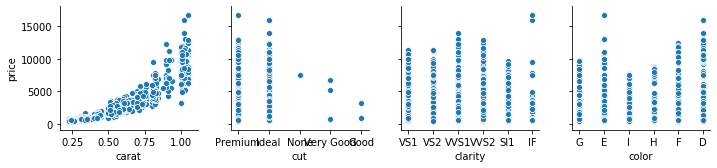

In [179]:
#df['size']=df['l']*df['w']*df['d']
sns.pairplot(df, x_vars=['carat', 'cut', 'clarity', 'color'], y_vars = ['price'])
plt.show()
#df.drop(['size'], axis=1, inplace=True)

#### 2. Convert categorical column to numerical column using labelencoder

In [180]:
def convert_catg(df1):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    # Find the columns of object type along with their column index
    object_cols = list(df1.select_dtypes(exclude=[np.number]).columns)
    object_cols_ind = []
    for col in object_cols:
        object_cols_ind.append(df1.columns.get_loc(col))

    # Encode the categorical columns with numbers    
    for i in object_cols_ind:
        df1.iloc[:,i] = le.fit_transform(df1.iloc[:,i])

convert_catg(df)
df.head(3)



,carat,cut,color,clarity,depth,table,lab,sym,pol,flr,hna,price
6,0.40,3,3,2,61.6,56.0,1,4,4,2,0,1191
7,0.81,1,3,3,61.6,57.0,0,2,2,2,1,4391
8,0.81,1,3,3,61.0,57.0,0,2,2,2,1,4396


#### 3. Plot histogram for every feature including price

* Define histplot function

In [181]:
def histplot(df, listvar, bins):
    fig, axes = plt.subplots(nrows=1, ncols=len(listvar), figsize=(20, 3))
    counter=0
    for ax in axes:
        df.hist(column=listvar[counter], bins=bins, ax=axes[counter])
        plt.ylabel('Price')
        plt.xlabel(listvar[counter])
        counter = counter+1
    plt.show()


* plot histogram for every feature now

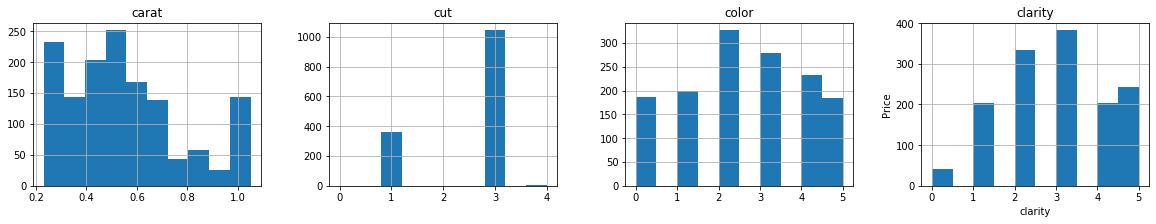

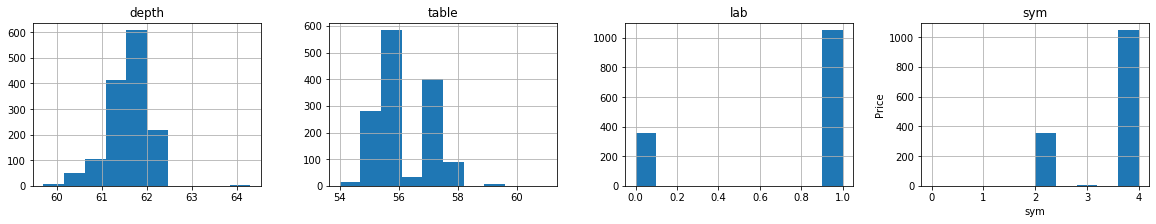

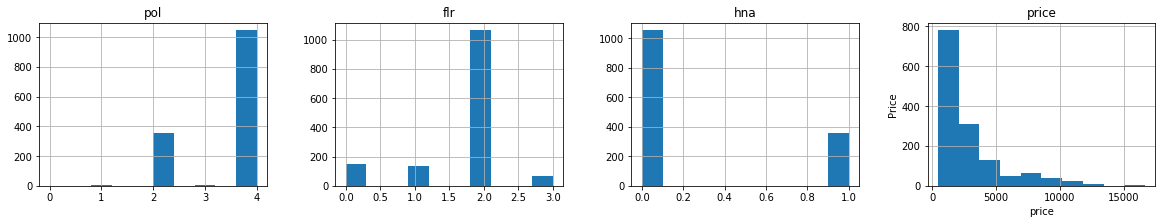

In [182]:
linear_vars = df.select_dtypes(include=[np.number]).columns
histplot(df,linear_vars[0:4], bins=10)
histplot(df,linear_vars[4:8], bins=10)
histplot(df,linear_vars[8:], bins=10)

#### 4. View outliers

In [183]:
def sorteddf(df, listvar):
    for var in listvar:
        display('sorted by ' + var + ' --> ' + str(list(df[listvar].sort_values(by=var,ascending=False)[var].head())))

sorteddf(df, linear_vars)      

'sorted by carat --> [1.05, 1.05, 1.05, 1.05, 1.05]'

'sorted by cut --> [4, 4, 4, 4, 3]'

'sorted by color --> [5, 5, 5, 5, 5]'

'sorted by clarity --> [5, 5, 5, 5, 5]'

'sorted by depth --> [64.3, 64.2, 63.4, 63.1, 62.9]'

'sorted by table --> [61.0, 60.0, 59.0, 59.0, 59.0]'

'sorted by lab --> [1, 1, 1, 1, 1]'

'sorted by sym --> [4, 4, 4, 4, 4]'

'sorted by pol --> [4, 4, 4, 4, 4]'

'sorted by flr --> [3, 3, 3, 3, 3]'

'sorted by hna --> [1, 1, 1, 1, 1]'

'sorted by price --> [16680, 15983, 13859, 12994, 12882]'

Lets visualise those using boxplots

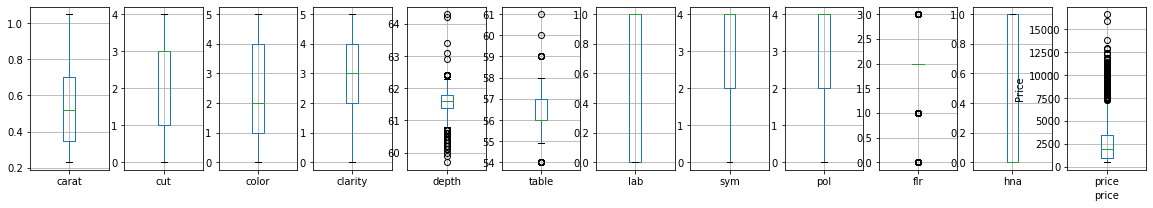

In [184]:
def dfboxplot(df, listvar):
    fig, axes = plt.subplots(nrows=1, ncols=len(listvar), figsize=(20, 3))
    counter=0
    for ax in axes:
        df.boxplot(column=listvar[counter], ax=axes[counter])
        plt.ylabel('Price')
        plt.xlabel(listvar[counter])
        counter = counter+1
    plt.show()

dfboxplot(df, linear_vars)


<font color = 'navy'><i><b>4. Convert to log</b></i></font>

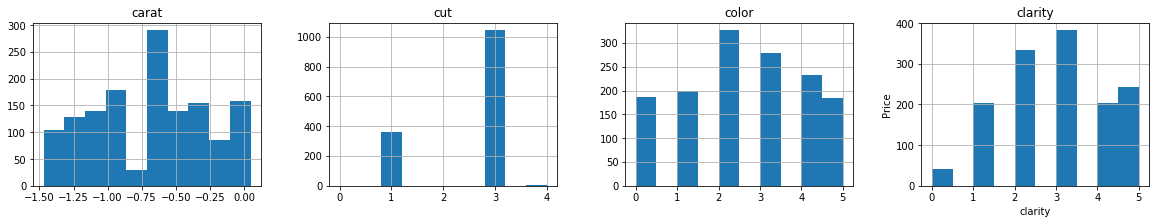

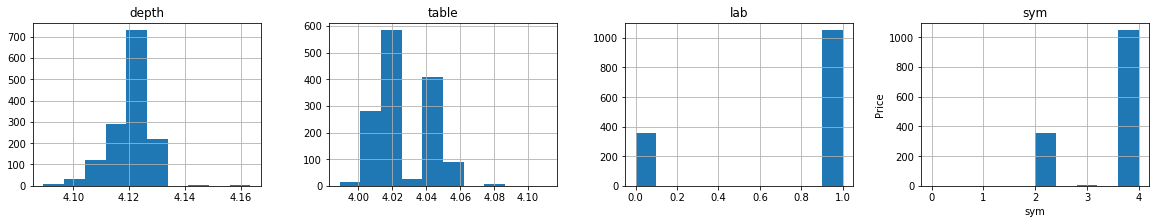

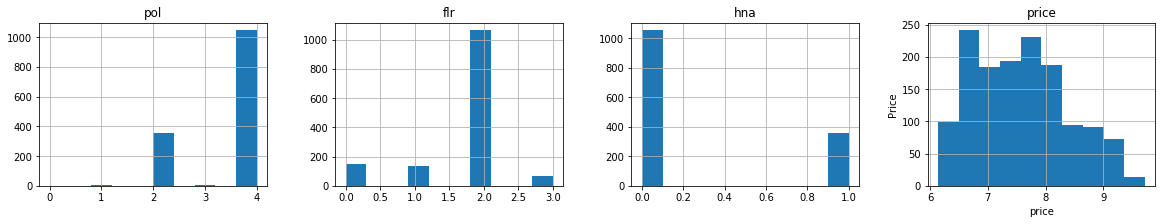

In [185]:
# this log converts dataframe's features inplace
def convertfeatures2log(df, listvars):
    for var in listvars:
        df[var] = np.log(df[var])

convertfeatures2log(df, ['carat', 'depth', 'table', 'price'])
histplot(df,linear_vars[0:4], bins=10)
histplot(df,linear_vars[4:8], bins=10)
histplot(df,linear_vars[8:], bins=10)


## Data Preprocessing

### 1. Determine mean values of categories of all category columns like cut, clarity and color
* Do a dataframe groupby to find mean. 

* Sort_values sorts result by resulting values, NOT but category label

In [186]:

# Addind a new column in same DF 
# df['price/wt']=df['price']/df['carat']

# IMP: groupby in pandas dataframe
print(df.groupby('cut')['price'].mean().sort_values())
print(df.groupby('color')['price'].mean().sort_values())
print(df.groupby('clarity')['price'].mean().sort_values())

# df = df.drop(['price/wt'], axis=1)


cut
0    7.433709
3    7.488936
1    7.865529
4    8.158049
2    8.930626
Name: price, dtype: float64
color
4    7.522740
3    7.534801
5    7.546941
2    7.606852
1    7.630757
0    7.706644
Name: price, dtype: float64
clarity
1    7.469443
3    7.557181
2    7.571638
0    7.603729
5    7.630636
4    7.734033
Name: price, dtype: float64


### 4. Set X and y now 
* NOTE: two quare brackets [[... ]] are needed to create a datarame. 
* Single [] will create a series / array

In [187]:
X_df = df.drop(['price'], axis=1)
display(X_df.head(3))

y_df = df[['price']] # two [[ to create a DF. Single [] will create a series / array
display(y_df.head(3))

,carat,cut,color,clarity,depth,table,lab,sym,pol,flr,hna
6,-0.916291,3,3,2,4.120662,4.025352,1,4,4,2,0
7,-0.210721,1,3,3,4.120662,4.043051,0,2,2,2,1
8,-0.210721,1,3,3,4.110874,4.043051,0,2,2,2,1


,price
6,7.082549
7,8.387312
8,8.388450


### 5.  Determine correlation between price vs all other attributes.
* seems price is highly corr with carat (and dimensions) and fairly with color and clarity, not much with cut
* combining both X (already converted categorical to numerical) and y to form a new dataframe for correlation

> * **df_le = X_df** --> df_le will be like a pointer to X_df. Any change made to df_le will actually be a change to X_df
> * So, df_le = X_df.**copy()** is better

In [188]:
df_le = X_df.copy()

# add a new column in dataframe - join 2 dataframe columns-wise
df_le['price'] = y_df['price'].values
df_le.corr()


,carat,cut,color,clarity,depth,table,lab,sym,pol,flr,hna,price
carat,1.000000,-0.227000,0.102544,-0.023613,0.039393,0.204458,-0.227405,-0.237623,-0.231543,0.054660,0.229536,0.963835
cut,-0.227000,1.000000,-0.058305,0.201631,0.043172,-0.111751,0.989376,0.985790,0.975246,-0.208309,-0.974516,-0.196432
color,0.102544,-0.058305,1.000000,-0.079998,0.034412,0.011204,-0.052867,-0.060526,-0.067440,0.045568,0.064487,-0.067419
clarity,-0.023613,0.201631,-0.079998,1.000000,-0.045238,-0.010072,0.201366,0.206650,0.214137,-0.028839,-0.203227,0.064900
depth,0.039393,0.043172,0.034412,-0.045238,1.000000,-0.425406,0.053506,0.017152,0.025119,0.003308,-0.072570,0.018577
table,0.204458,-0.111751,0.011204,-0.010072,-0.425406,1.000000,-0.112664,-0.125245,-0.129512,-0.019839,0.133323,0.174333
lab,-0.227405,0.989376,-0.052867,0.201366,0.053506,-0.112664,1.000000,0.980630,0.972778,-0.211673,-0.984997,-0.200130
sym,-0.237623,0.985790,-0.060526,0.206650,0.017152,-0.125245,0.980630,1.000000,0.983955,-0.195843,-0.965791,-0.202796
pol,-0.231543,0.975246,-0.067440,0.214137,0.025119,-0.129512,0.972778,0.983955,1.000000,-0.193065,-0.965360,-0.193830
flr,0.054660,-0.208309,0.045568,-0.028839,0.003308,-0.019839,-0.211673,-0.195843,-0.193065,1.000000,0.201550,0.067750


<img src="diam_attr.jpg" alt="Diamond Attributes" style="width: 400px;"/>
https://www.gia.edu/diamond-cut/diamond-cut-anatomy-round-brilliant

* IDEAL cut has table and depth values along with crown, pavilion, culet etc in a emperically defined range

#### Feature scaling - seems not needed here since we have log1p the price

In [28]:
'''from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()

 
# why fit_transform to X_train whereas transform to X_test?
# Becasue StandardScaler has to be first fitted to X_train. Then StandardScaler will understand data type and wd need only transform
      
X_df = sc_X.fit_transform(X_df)
X_df[0:3]

'''

'from sklearn.preprocessing import StandardScaler\nsc_X = StandardScaler()\n\n \n# why fit_transform to X_train whereas transform to X_test?\n# Becasue StandardScaler has to be first fitted to X_train. Then StandardScaler will understand data type and wd need only transform\n      \nX_df = sc_X.fit_transform(X_df)\nX_df[0:3]\n\n'

# Run ML Model


#### train test split

In [189]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=42)

X_train.head()

,carat,cut,color,clarity,depth,table,lab,sym,pol,flr,hna
1176,-0.634878,3,3,4,4.122284,4.025352,1,4,4,0,0
300,-0.356675,3,3,2,4.131961,4.025352,1,4,4,2,0
1158,-0.891598,3,3,2,4.117410,4.025352,1,4,4,0,0
899,-0.510826,1,1,3,4.110874,4.039536,0,2,2,2,1
780,-0.186330,3,3,4,4.125520,4.043051,1,4,4,2,0


In [30]:
# y_test['price'].rename_axis('ID').values

### Linear ML model

In [190]:
from sklearn.linear_model import LinearRegression

reg_all = LinearRegression()
reg_all.fit(X_train,y_train)

y_pred=reg_all.predict(X_test)


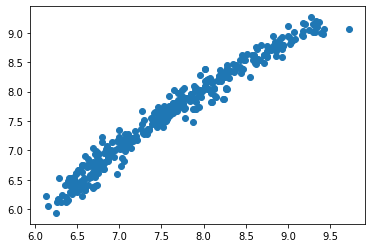

In [191]:
import  matplotlib.pyplot as plt
plt.scatter(y_test,y_pred)

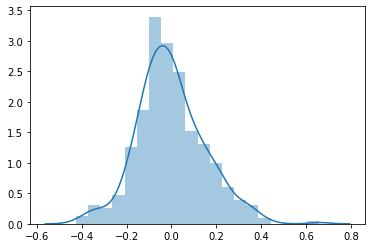

In [192]:
import seaborn as sns
sns.distplot((y_test-y_pred),bins=20);

### Regression Evaluation Metrics


Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

In [193]:
from sklearn import metrics

# The following are 

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.11652136924155168
MSE: 0.02292105733384392
RMSE: 0.15139701890672722


### KNN

In [194]:
X_test.head()

,carat,cut,color,clarity,depth,table,lab,sym,pol,flr,hna
359,-0.494296,3,3,2,4.115780,4.025352,1,4,4,2,0
870,-0.616186,3,4,3,4.102643,4.025352,1,4,4,2,0
1168,-0.673345,3,0,5,4.123903,4.025352,1,4,4,0,0
198,0.019803,3,5,2,4.112512,4.025352,1,4,4,2,0
788,-0.616186,3,2,5,4.128746,4.025352,1,4,4,2,0


In [274]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold

reg_all = KNeighborsRegressor(n_neighbors = 3, metric = 'minkowski', p = 2)
kfold = KFold(n_splits=10)
results = cross_val_score(reg_all, X_train, y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))




Results: 0.77 (0.04) MSE


In [275]:
y_test.head()

,price
359,7.863651
870,7.531016
1168,7.869784
198,8.826735
788,7.843064


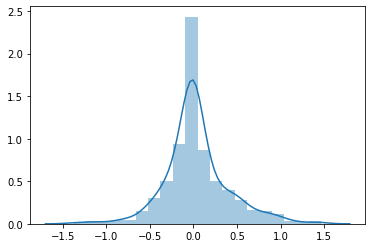

In [276]:
sns.distplot(y_test-y_pred,bins=20)


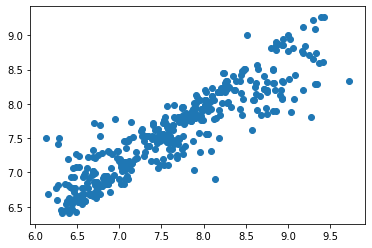

In [277]:
plt.scatter(y_test,y_pred)

In [278]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.2453726742095868
MSE: 0.13443692717163525
RMSE: 0.3666564156968145


### Polynomial regression

In [200]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

reg_all = LinearRegression()
reg_all.fit(X_train_poly,y_train)
y_pred=reg_all.predict(X_test_poly)

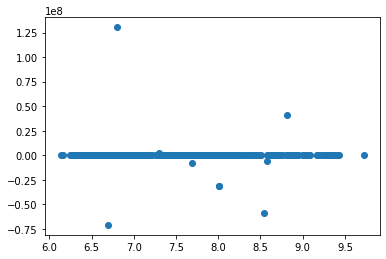

In [201]:
plt.scatter(y_test,y_pred)

In [202]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 898726.9045508087
MSE: 69247544326063.85
RMSE: 8321510.94009158


### SVM support vector machines


In [203]:
from sklearn.svm import SVR

regressor = SVR(kernel='rbf')
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\program files\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [204]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.11289679119235742
MSE: 0.02766726274929755
RMSE: 0.16633479115716457


### Random forest

In [205]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 10)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


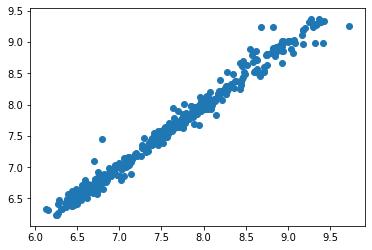

In [206]:
plt.scatter(y_test,y_pred)

In [207]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.06967070893162644
MSE: 0.01118751456392355
RMSE: 0.10577104785300914


### Neural network

In [208]:
from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras.optimizers import RMSprop

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


#### Check whether you have tensorflow-gpu?
https://medium.com/@kegui/how-do-i-know-i-am-running-keras-model-on-gpu-a9cdcc24f986

In [209]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 634542309881461100
]


#### https://keras.io/scikit-learn-api/
#### https://www.programcreek.com/python/example/88638/keras.wrappers.scikit_learn.KerasRegressor
1. construct, compile and return a Keras model, which will then be used to fit/predict.
2. Predict diamond prices
3. ypred vs. ytest now


In [217]:

# define base model
def baseline_model():
    # create model
    model = Sequential()
    # add 1st layer
    model.add(Dense(output_dim=18, input_dim=11, activation='relu')) # kernel_initializer='normal',
    # add hidden layer
    model.add(Dense(output_dim=12, kernel_initializer='normal', activation='relu'))
    # add output layer
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model



https://machinelearningmastery.com/5-step-life-cycle-neural-network-models-keras/

In [218]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=10, batch_size=2)

kfold = KFold(n_splits=5)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=11, activation="relu", units=18)`
  
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="normal", activation="relu", units=12)`
  


Epoch 1/10
788/788 [==============================] - 0s 422us/step - loss: 14.4936
Epoch 2/10
788/788 [==============================] - 0s 362us/step - loss: 1.0835
Epoch 3/10
788/788 [==============================] - 0s 358us/step - loss: 0.6221
Epoch 4/10
788/788 [==============================] - 0s 372us/step - loss: 0.2955
Epoch 5/10
788/788 [==============================] - 0s 357us/step - loss: 0.1042
Epoch 6/10
788/788 [==============================] - 0s 365us/step - loss: 0.0470
Epoch 7/10
788/788 [==============================] - 0s 362us/step - loss: 0.0356
Epoch 8/10
788/788 [==============================] - 0s 376us/step - loss: 0.0334
Epoch 9/10
788/788 [==============================] - 0s 384us/step - loss: 0.0340
Epoch 10/10
197/197 [==============================] - 0s 268us/step
Epoch 1/10
788/788 [==============================] - 0s 451us/step - loss: 8.2042
Epoch 2/10
788/788 [==============================] - 0s 419us/step - loss: 0.5918
Epoch 3/10
788/78

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=11, activation="relu", units=18)`
  
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="normal", activation="relu", units=12)`
  


Epoch 1/10
985/985 [==============================] - 0s 404us/step - loss: 8.9889
Epoch 2/10
985/985 [==============================] - 0s 350us/step - loss: 0.6913
Epoch 3/10
985/985 [==============================] - 0s 353us/step - loss: 0.2775
Epoch 4/10
985/985 [==============================] - 0s 350us/step - loss: 0.0788
Epoch 5/10
985/985 [==============================] - 0s 355us/step - loss: 0.0380
Epoch 6/10
985/985 [==============================] - 0s 367us/step - loss: 0.0330
Epoch 7/10
985/985 [==============================] - 0s 390us/step - loss: 0.0312
Epoch 8/10
985/985 [==============================] - 0s 377us/step - loss: 0.0273
Epoch 9/10
985/985 [==============================] - 0s 353us/step - loss: 0.0277
Epoch 10/10
985/985 [==============================] - 0s 351us/step - loss: 0.0300


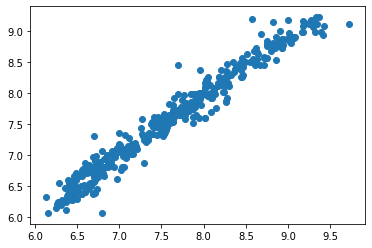

In [219]:
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
y_pred[0:5]

plt.scatter(y_test,y_pred)
#accuracy_score(y_test, prediction)
